## 2 Integração e Limpeza de Dados

Nesta seção, integramos as fontes, limpamos o dataset e realizamos diagnósticos de qualidade para garantir dados prontos para análise.

### 2.0 Verificação de Pré-requisitos
Esta célula verifica se os três arquivos CSV necessários existem em `data/`.
Se algum arquivo estiver faltando, será impresso um erro e a execução será interrompida.

In [52]:
# Bibliotecas

# Stdlib
from pathlib import Path
import sys
import json

# Third-party
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display


print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [53]:
data_dir = Path('data')
required = ['all_data.csv', 'id_name.csv', 'steam_app_data.csv']
missing = []
for name in required:
    if not (data_dir / name).exists():
        missing.append(name)

if missing:
    msg = f'Erro: arquivos ausentes em {data_dir}: {missing}'
    print(msg)
    sys.exit(1)

print('Todos os arquivos CSV requeridos estão presentes.')

Todos os arquivos CSV requeridos estão presentes.


In [54]:

path = "data/"

# Carrega só o cabeçalho (sem dados)
steam_columns = pd.read_csv(path + "steam_app_data.csv", nrows=0).columns
all_columns = pd.read_csv(path + "all_data.csv", nrows=0).columns

cols_all = set(all_columns)
cols_steam = set(steam_columns)

# Lista completa e ordenada de colunas
all_cols = sorted(list(cols_all.union(cols_steam)))

# Cria DataFrame com ícones em vez de True/False
comparison_df = pd.DataFrame({
    "Coluna": all_cols,
    "Presente em all_data": ["True" if col in cols_all else "False" for col in all_cols],
    "Presente em steam_app_data": ["True" if col in cols_steam else "False" for col in all_cols]
})

display(comparison_df)


,Coluna,Presente em all_data,Presente em steam_app_data
0,Unnamed: 0,True,False
1,about_the_game,False,True
2,achievements,False,True
3,appid,True,False
4,average_2weeks,True,False
5,average_forever,True,False
6,background,False,True
7,categories,False,True
8,ccu,True,False
9,content_descriptors,False,True


In [55]:
path = "data/"

chunk_size = 100_000  # tamanho dos blocos
output_path = path + "merged_data.csv"

cols_keep = [
    'appid', 'name',
    'is_free', 'price', 'initialprice', 'price_overview',
    'owners', 'ccu',
    'positive', 'negative', 'userscore',
    'average_forever', 'median_forever', 'average_2weeks',
    'genres', 'categories',
    'platforms', 'release_date',
    'developers', 'publishers', 'metacritic'
]

# Carregar apenas cabeçalhos
steam_columns = pd.read_csv(path + "steam_app_data.csv", nrows=0).columns
all_columns = pd.read_csv(path + "all_data.csv", nrows=0).columns

steam_cols = [c for c in cols_keep if c in steam_columns]
all_cols = [c for c in cols_keep if c in all_columns]

# Lê steam_app_data em chunks
steam_chunks = []
for i, chunk in enumerate(pd.read_csv(path + "steam_app_data.csv", usecols=steam_cols + ['steam_appid'], chunksize=chunk_size)):
    chunk.rename(columns={"steam_appid": "appid"}, inplace=True)
    steam_chunks.append(chunk)
    print(f"Chunk {i+1} lido: {len(chunk)} linhas")

steam_data = pd.concat(steam_chunks, ignore_index=True)
del steam_chunks  # libera RAM

# Lê all_data (geralmente menor)
all_data = pd.read_csv(path + "all_data.csv", usecols=all_cols + ['appid', 'name'])

# Faz merge
merged_df = pd.merge(all_data, steam_data, on=["appid", "name"], how="left")

# Salva o dataset integrado
merged_df.to_csv(output_path, index=False, encoding="utf-8")

print(f" Dataset integrado salvo em: {output_path}")
print(f" Formato final: {merged_df.shape[0]:,} linhas × {merged_df.shape[1]} colunas")


Chunk 1 lido: 86538 linhas
 Dataset integrado salvo em: data/merged_data.csv
 Formato final: 94,498 linhas × 21 colunas


### 2.2 Limpeza de Dados
Limpa os dados, padroniza as colunas, converte tipos

In [56]:

import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup

path = "data/merged_data.csv"

df = pd.read_csv(path, low_memory=False)
original_shape = df.shape
print(f"Dataset original: {original_shape[0]:,} linhas × {original_shape[1]} colunas")

# --- Remover colunas totalmente vazias ---
df = df.drop(columns=[c for c in df.columns if df[c].isna().all()], errors="ignore")

# --- Padronizar nomes de colunas ---
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# --- Preencher valores ausentes ---
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna("desconhecido")
    else:
        df[col] = df[col].fillna(df[col].mean())

# --- Conversão de tipos ---
cols_int = ["appid", "positive", "negative", "ccu", "average_forever", "median_forever", "average_2weeks"]
for c in cols_int:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

cols_float = ["price", "initialprice", "userscore", "metacritic"]
for c in cols_float:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

if "is_free" in df.columns:
    df["is_free"] = df["is_free"].astype(str).str.lower().isin(["true", "1", "yes"])

# --- Extração e padronização de preços ---
def extract_price_info(x, key):
    if isinstance(x, str) and "{" in x and "}" in x:
        try:
            fixed = x.replace("'", "\"").replace("False", "false").replace("True", "true")
            data = json.loads(fixed)
            value = data.get(key)
            if isinstance(value, (int, float)):
                return value / 100
        except Exception:
            return np.nan
    return np.nan

if "price_overview" in df.columns:
    df["price_final_json"] = df["price_overview"].apply(lambda x: extract_price_info(x, "final"))
    df["price_initial_json"] = df["price_overview"].apply(lambda x: extract_price_info(x, "initial"))

    df["price_final"] = df["price_final_json"]
    if "price" in df.columns:
        df["price_final"] = df["price_final"].fillna(df["price"])

    df["price_initial"] = df["price_initial_json"]
    if "initialprice" in df.columns:
        df["price_initial"] = df["price_initial"].fillna(df["initialprice"])
else:
    print("'price_overview' não encontrado — usando colunas price e initialprice como estão.")

# --- Extração da moeda ---
def extract_currency(x):
    if isinstance(x, str) and "{" in x and "}" in x:
        try:
            fixed = x.replace("'", "\"").replace("False", "false").replace("True", "true")
            data = json.loads(fixed)
            return data.get("currency", "desconhecido")
        except Exception:
            return "desconhecido"
    return "desconhecido"

df["currency"] = df["price_overview"].apply(extract_currency) if "price_overview" in df.columns else "desconhecido"

# --- Limpeza de HTML e texto ---
text_cols = ["genres", "categories", "developers", "publishers"]
for c in text_cols:
    if c in df.columns:
        df[c] = df[c].apply(lambda x: BeautifulSoup(str(x), "html.parser").get_text() if pd.notnull(x) else x)
        df[c] = df[c].str.lower().str.strip()

# --- Outliers ---
for col in ["price", "userscore", "metacritic"]:
    if col in df.columns:
        low, high = df[col].quantile([0.01, 0.99])
        df[col] = df[col].clip(lower=low, upper=high)

# --- Owners ---
if "owners" in df.columns:
    df["owners"] = (
        df["owners"]
        .astype(str)
        .str.replace(",", "")
        .str.extract(r"(\d+)", expand=False)
        .astype(float)
        .fillna(0)
    )

# --- Metacritic ---
if "metacritic" in df.columns:
    df["metacritic"] = df["metacritic"].apply(
        lambda x: extract_price_info(x, "score") if isinstance(x, str) and "{" in x else x
    )

# --- Duplicatas ---
df = df.drop_duplicates(subset=["appid"], keep="first")

# --- Filtro: apenas jogos com dados válidos ---
before_filter = df.shape[0]
df = df.loc[df["price_final"] >= 0]
df = df.loc[~df["genres"].isin(["desconhecido", "", "none", "null"])]
removed_missing = before_filter - df.shape[0]

# --- Salvar resultado ---
output_path = "data/merged_data_clean.csv"
df.to_csv(output_path, index=False)

# --- Relatório ---
print("\nRelatório de Limpeza")
print("------------------------------------------")
print(f"Linhas iniciais: {original_shape[0]:,}")
print(f"Linhas finais:   {df.shape[0]:,}")
print(f"Linhas removidas: {original_shape[0] - df.shape[0]:,}")
print(f"Linhas removidas por dados faltantes: {removed_missing:,}")
print(f"Arquivo final salvo em: {output_path}")

print("\nMoedas presentes no dataset final:")
print(df["currency"].value_counts().head(30))


Dataset original: 94,498 linhas × 21 colunas

Relatório de Limpeza
------------------------------------------
Linhas iniciais: 94,498
Linhas finais:   80,845
Linhas removidas: 13,653
Linhas removidas por dados faltantes: 1,655
Arquivo final salvo em: data/merged_data_clean.csv

Moedas presentes no dataset final:
currency
BRL             69459
desconhecido    10677
EUR               275
USD               239
GBP                54
RUB                27
CAD                16
AUD                15
PLN                13
PHP                 8
UAH                 8
CNY                 6
NOK                 6
MYR                 5
MXN                 4
HKD                 4
SGD                 4
ILS                 3
KZT                 3
CLP                 2
COP                 2
SAR                 2
CHF                 2
JPY                 2
IDR                 1
VND                 1
ZAR                 1
NZD                 1
KWD                 1
TWD                 1
Name: count, dtyp

### 2.1 Enriquecimento com Fontes Externas (Opcional)
Identifique e integre dados externos relevantes (demográficos, econômicos, clima, etc.) usando estratégias de matching (IDs, tempo, geografia, categorias). Documente conflitos e duplicatas.

In [ ]:
# Converte todas as moedas para BRL usando exchangerate.host e remove linhas com preço nulo

# caminho para o dataset já limpo (ou o merged)
input_path = "data/merged_data_clean.csv"         # ou "data/merged_data_clean.csv" se já existir
output_path = "data/merged_data_clean_brl.csv"

df = pd.read_csv(input_path, low_memory=False)

# coluna que contém o preço extraído (em reais) a partir do price_overview
# (ajuste se você usou outro nome: price_final, price_final_json, price_final_brl, etc.)
price_col = "price_final"   # coluna com preço na moeda original (ex: 16.99)
currency_col = "currency"   # coluna que identificou a moeda (ex: 'BRL', 'EUR')

print(f"Linhas iniciais: {len(df):,}")

# --- quais moedas temos (top) ---
print("\nMoedas encontradas (top):")
print(df[currency_col].value_counts().head(40))

# --- lista única de moedas a converter (exclui 'desconhecido' e NaN) ---
currencies = sorted(df.loc[df[currency_col].notna(), currency_col].unique())
currencies = [c for c in currencies if c not in ("desconhecido", "", "None", "none", None)]
print("\nMoedas para converter:", currencies)

# --- Busca taxas na API exchangerate.host (base = BRL) ---
# Nota: a API retorna rates como "1 BRL = X USD", portanto para converter valor em USD -> BRL:
# price_brl = price_usd / rates['USD']
api_url = "https://api.exchangerate.host/latest"
params = {"base": "BRL", "symbols": ",".join(currencies)}  # pedimos apenas as moedas presentes

exchange_rates = {}
use_api = True
try:
    print("\nBuscando taxas de câmbio na exchangerate.host...")
    r = requests.get(api_url, params=params, timeout=10)
    r.raise_for_status()
    data = r.json()
    rates = data.get("rates", {})
    # rates: 1 BRL = rates['USD'] USD, etc.
    # Para converter X currency_units -> BRL: BRL = X / rates[currency]
    exchange_rates = {cur: rates.get(cur) for cur in currencies}
    print("Taxas obtidas:", exchange_rates)
except Exception as e:
    print("Falha ao obter taxas da API:", str(e))
    use_api = False

# --- fallback manual (preencher se API falhar) ---
if not use_api or any(v is None for v in exchange_rates.values()):
    # Preencha/ajuste conforme necessidade. Valores fictícios de exemplo (não usar em produção).
    exchange_rates_manual = {
        "BRL": 1.0,
        "USD": 0.18,  # 1 BRL = 0.18 USD  -> 1 USD ~= 5.56 BRL
        "EUR": 0.16,
        "GBP": 0.13,
        # ... adicione conforme necessário
    }
    for cur in currencies:
        if exchange_rates.get(cur) is None:
            if cur in exchange_rates_manual:
                exchange_rates[cur] = exchange_rates_manual[cur]
            else:
                exchange_rates[cur] = None

# --- Converter por linha: price_brl = price_original / rates[currency] (when rate != 0) ---
def convert_to_brl(price, currency):
    try:
        price = float(price)
    except Exception:
        return 0.0  # trata strings inválidas como 0

    # se o jogo for grátis (preço = 0)
    if price == 0:
        return 0.0

    # se a moeda for desconhecida, assume BRL
    if not currency or str(currency).lower() in ("desconhecido", "none", "nan"):
        return price  # já está em BRL (ou grátis)

    rate = exchange_rates.get(currency)
    if rate in (None, 0):
        return np.nan
    return price / rate


# Aplica conversão (vectorizado com .apply)
df["price_brl"] = df.apply(lambda r: convert_to_brl(r.get(price_col), r.get(currency_col)), axis=1)

# --- Relatórios e remoção de NaNs ---
before = len(df)
# Linhas sem preço convertido
no_price_mask = df["price_brl"].isna()
print("\nLinhas sem conversão (price_brl NaN):", no_price_mask.sum())

# Se quiser, mostrar amostra das linhas com problema
if no_price_mask.sum() > 0:
    print("\nExemplos de price_overview/currency problemáticos (mostrando 10):")
    cols_show = [currency_col, price_col, "price_overview"] if "price_overview" in df.columns else [currency_col, price_col]
    print(df.loc[no_price_mask, cols_show].head(10).to_string(index=False))

# Remove linhas com price_brl null (como pediu: "matar qualquer coisa que seja null e nan")
df = df.loc[~df["price_brl"].isna()].copy()
after_price_filter = len(df)
print(f"\nLinhas removidas por falta de preço convertido: {before - after_price_filter:,}")

# (Opcional) limpar further nulls em outras colunas essenciais:
essential_cols = ["userscore", "genres"]  # ajustar conforme sua necessidade
before2 = len(df)
df = df.dropna(subset=essential_cols)
after2 = len(df)
print(f"Linhas removidas por falta de {essential_cols}: {before2 - after2:,}")



# --- salvar resultado final ---
df.to_csv(output_path, index=False)
print(f"\nArquivo salvo: {output_path}")
print(f"Linhas finais: {len(df):,}")


Linhas iniciais: 80,845

Moedas encontradas (top):
currency
BRL             69459
desconhecido    10677
EUR               275
USD               239
GBP                54
RUB                27
CAD                16
AUD                15
PLN                13
PHP                 8
UAH                 8
CNY                 6
NOK                 6
MYR                 5
MXN                 4
HKD                 4
SGD                 4
ILS                 3
KZT                 3
CLP                 2
COP                 2
SAR                 2
CHF                 2
JPY                 2
IDR                 1
VND                 1
ZAR                 1
NZD                 1
KWD                 1
TWD                 1
INR                 1
AED                 1
KRW                 1
Name: count, dtype: int64

Moedas para converter: ['AED', 'AUD', 'BRL', 'CAD', 'CHF', 'CLP', 'CNY', 'COP', 'EUR', 'GBP', 'HKD', 'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'KWD', 'KZT', 'MXN', 'MYR', 'NOK', 'NZD', 'PHP', 'P

### 2.3 Consultas SQL e Visualizações para Diagnóstico de Qualidade
Heatmaps de missing, boxplots, distribuições antes/depois e consultas que evidenciem problemas e validem correções.

Dados brutos: 94,498 linhas
Dados limpos: 70,027 linhas

Valores ausentes nos dados brutos:
metacritic        90353
price_overview    13991
categories         2474
publishers         2230
developers         1801
genres             1733
release_date       1567
is_free            1567
platforms          1567
price                28
dtype: int64

Valores ausentes nos dados limpos:
appid              0
name               0
positive           0
negative           0
userscore          0
owners             0
average_forever    0
average_2weeks     0
median_forever     0
price              0
dtype: int64


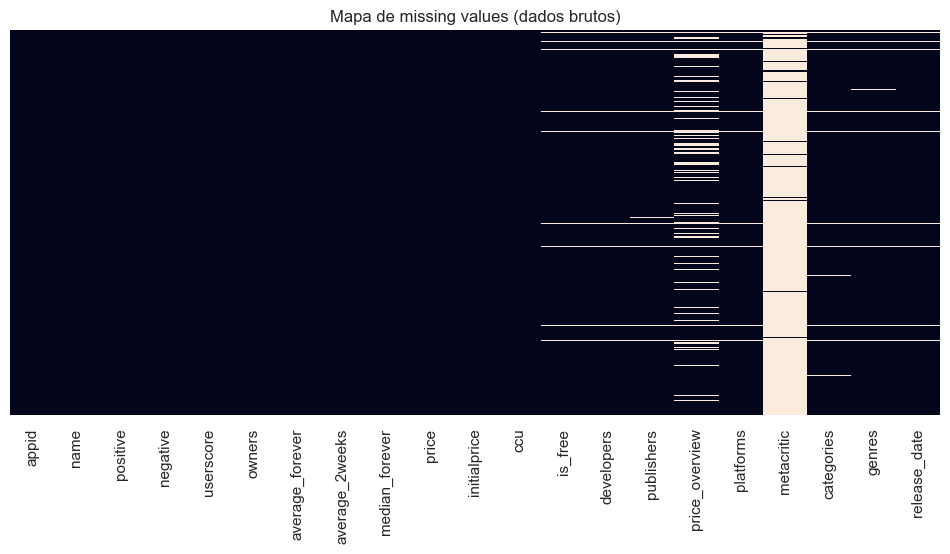

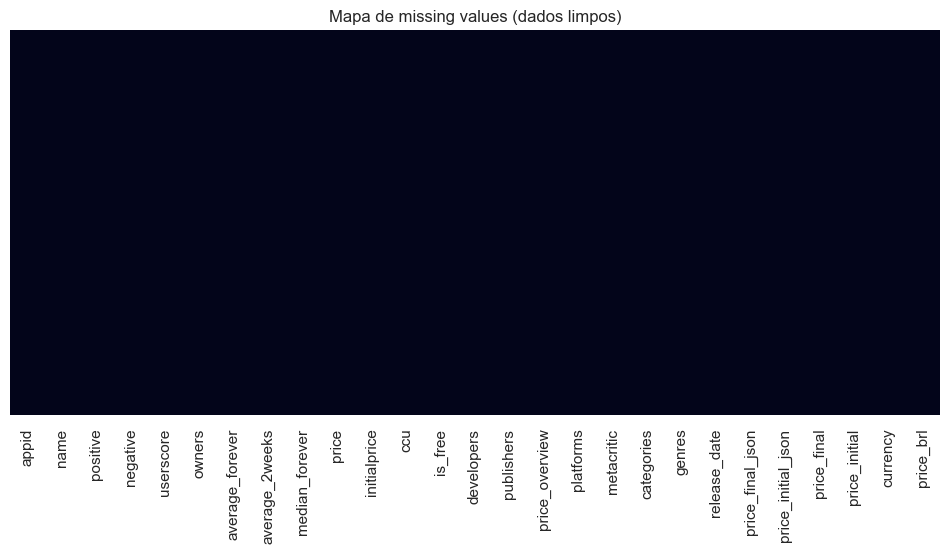

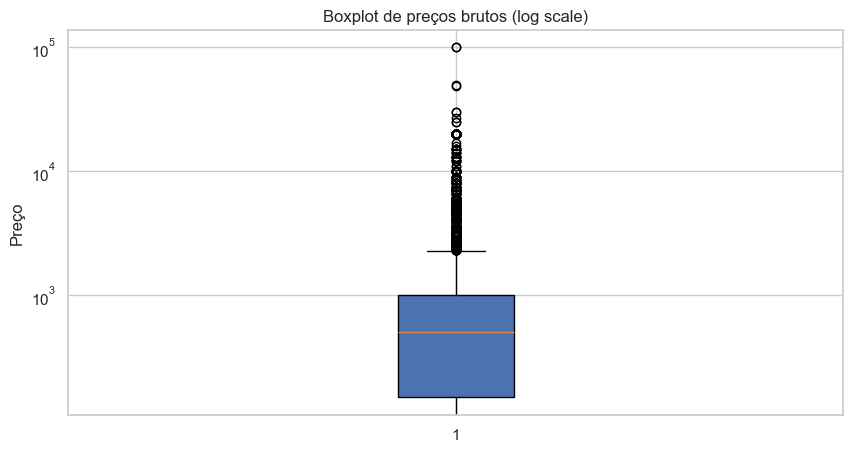

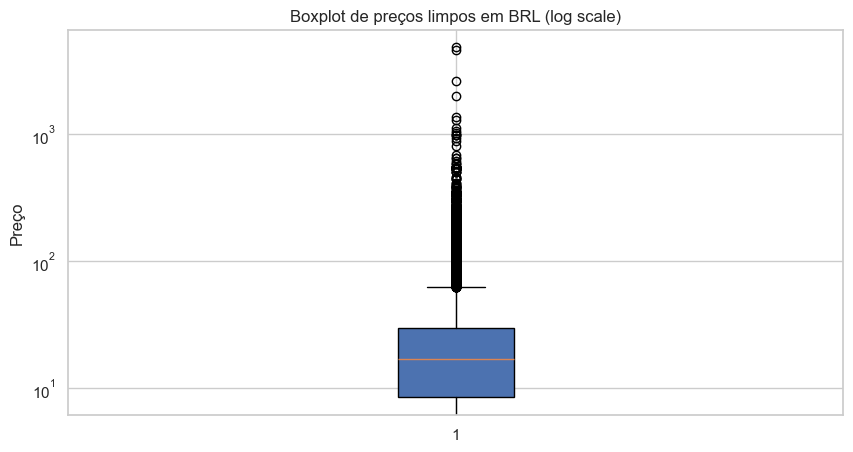

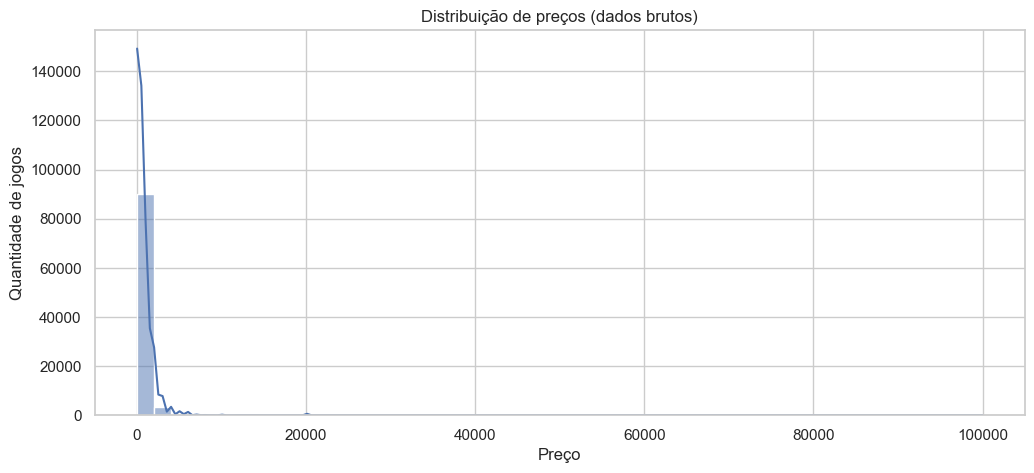

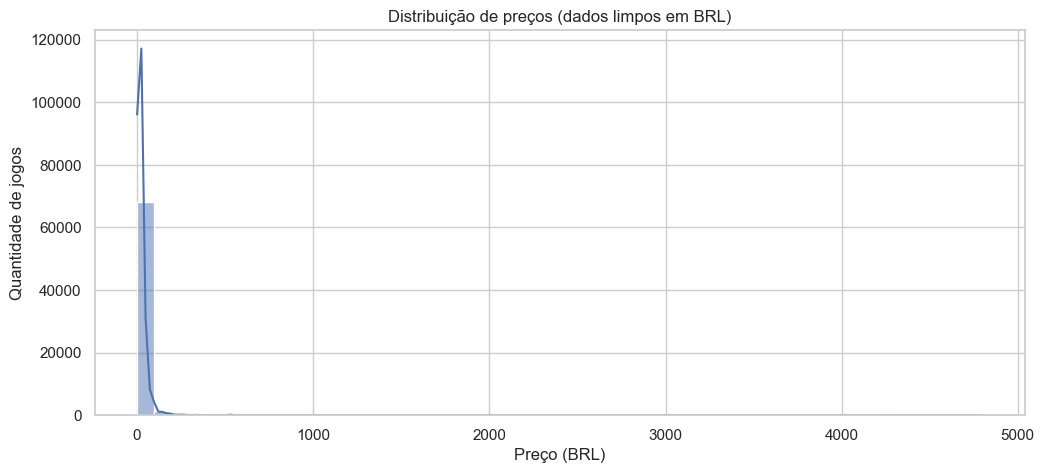


Problemas de moeda e preços nos dados brutos:
        currency    qtd    avg_price  max_price
0            BRL  79762   845.662258    99998.0
1   desconhecido  13991   144.606603    48445.0
2            EUR    299  1150.672241     5999.0
3            USD    240  1815.120833     8999.0
4            GBP     55  1936.272727     6999.0
5            RUB     35  1266.571429     4999.0
6            CAD     16  1769.625000     5999.0
7            AUD     15  1333.000000     5999.0
8            PLN     13   804.384615     2999.0
9            PHP      9  1787.888889     3999.0
10           UAH      8  1699.000000     4999.0
11           NOK      6  1894.000000     5999.0
12           CNY      6  1282.333333     2999.0
13           SGD      5  1559.000000     1999.0
14           MYR      5  2299.000000     5999.0
15           MXN      4  1424.000000     2999.0
16           HKD      4  2749.000000     5999.0
17           ILS      3  1995.666667     2999.0
18           KZT      3  1865.666667     

In [58]:
# --- Carregar dados brutos e limpos ---
df_raw = pd.read_csv("data/merged_data.csv")
df_clean = pd.read_csv("data/merged_data_clean_brl.csv")

print(f"Dados brutos: {len(df_raw):,} linhas")
print(f"Dados limpos: {len(df_clean):,} linhas")

# --- Registrar no DuckDB ---
duckdb.register("df_raw", df_raw)
duckdb.register("df_clean", df_clean)

# --- Diagnóstico de valores ausentes (missing values) ---
missing_raw = df_raw.isna().sum().sort_values(ascending=False)
missing_clean = df_clean.isna().sum().sort_values(ascending=False)

print("\nValores ausentes nos dados brutos:")
print(missing_raw.head(10))

print("\nValores ausentes nos dados limpos:")
print(missing_clean.head(10))

# --- Visualização de missing values ---
plt.figure(figsize=(12,5))
sns.heatmap(df_raw.isna(), cbar=False, yticklabels=False)
plt.title("Mapa de missing values (dados brutos)")
plt.show()

plt.figure(figsize=(12,5))
sns.heatmap(df_clean.isna(), cbar=False, yticklabels=False)
plt.title("Mapa de missing values (dados limpos)")
plt.show()

# --- Outliers em preços (dados brutos vs limpos) ---
plt.figure(figsize=(10,5))
plt.boxplot(df_raw['price'].fillna(0), patch_artist=True)
plt.yscale('log')
plt.title("Boxplot de preços brutos (log scale)")
plt.ylabel("Preço")
plt.show()

plt.figure(figsize=(10,5))
plt.boxplot(df_clean['price_brl'].fillna(0), patch_artist=True)
plt.yscale('log')
plt.title("Boxplot de preços limpos em BRL (log scale)")
plt.ylabel("Preço")
plt.show()

# --- Distribuição de preços antes/depois da limpeza ---
plt.figure(figsize=(12,5))
sns.histplot(df_raw['price'].dropna(), bins=50, kde=True)
plt.title("Distribuição de preços (dados brutos)")
plt.xlabel("Preço")
plt.ylabel("Quantidade de jogos")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df_clean['price_brl'].dropna(), bins=50, kde=True)
plt.title("Distribuição de preços (dados limpos em BRL)")
plt.xlabel("Preço (BRL)")
plt.ylabel("Quantidade de jogos")
plt.show()

# --- Diagnóstico SQL: moedas e preços no dataset bruto ---
# Criar coluna 'currency' no raw se não existir (somente para visualização comparativa)
if 'currency' not in df_raw.columns:
    def extract_currency(x):
        if isinstance(x, str) and "{" in x and "}" in x:
            try:
                return eval(x).get("currency", "desconhecido")
            except:
                return "desconhecido"
        return "desconhecido"
    df_raw['currency'] = df_raw['price_overview'].apply(extract_currency)
    duckdb.register("df_raw", df_raw)

query_raw_currency = """
SELECT
    currency,
    COUNT(*) AS qtd,
    AVG(price) AS avg_price,
    MAX(price) AS max_price
FROM df_raw
GROUP BY currency
ORDER BY qtd DESC
"""
raw_inconsistencies = duckdb.sql(query_raw_currency).df()
print("\nProblemas de moeda e preços nos dados brutos:")
print(raw_inconsistencies.head(20))

# --- Diagnóstico SQL: moedas e preços no dataset limpo ---
query_clean_currency = """
SELECT
    currency,
    COUNT(*) AS qtd,
    AVG(price_final) AS avg_price,
    MAX(price_final) AS max_price
FROM df_clean
GROUP BY currency
ORDER BY qtd DESC
"""
clean_inconsistencies = duckdb.sql(query_clean_currency).df()
print("\nProblemas de moeda e preços nos dados limpos:")
print(clean_inconsistencies.head(20))


## 3 Análise Exploratória e Consultas SQL
Nesta seção, preparamos os dados em formato tidy, executamos consultas SQL analíticas e conduzimos análises com visualizações e testes de hipóteses.

## 3.2 Preparação dos Dados em Formato Tidy
### 3.2.1 Organização dos Dados
Transformar o dataset limpo para formato tidy data seguindo os princípios fundamentais: cada
variável forma uma coluna, cada observação forma uma linha e cada tipo de unidade observacional forma uma tabela.

### 3.2.2 Reestruturação Necessária e Export para Parquet
- Salva todas as tabelas tidy em formato Parquet (eficiente para análise)
- Fallback para CSV se Parquet não estiver disponível

In [59]:
import re
import json
import pandas as pd
from dateutil import parser as dparser
import os

# ---------------------------------------------------------------------
# 1️⃣ Carregar dataset limpo
# ---------------------------------------------------------------------
clean_path = "data/merged_data_clean_brl.csv"
df = pd.read_csv(clean_path, low_memory=False)
print(f"📊 Dataset limpo carregado: {len(df):,} linhas × {df.shape[1]} colunas\n")

# ---------------------------------------------------------------------
# 2️⃣ PARSE DA COLUNA release_date
# ---------------------------------------------------------------------
def parse_release_date(val):
    """Extrai e converte datas de strings variadas (incluindo JSON-like)."""
    if not isinstance(val, str) or not val.strip():
        return pd.NaT
    s = val.strip()

    # JSON-like com campo 'date'
    if "date" in s and "{" in s:
        try:
            fixed = s.replace("'", '"')
            data = json.loads(fixed)
            if isinstance(data, dict) and "date" in data:
                return pd.to_datetime(data["date"], errors="coerce")
        except Exception:
            pass

    # Padrões comuns
    patterns = [
        r"(\d{1,2}\s+[A-Za-z]{3,9},?\s*\d{4})",
        r"([A-Za-z]{3,9}\s+\d{1,2},?\s*\d{4})",
        r"(\d{4}-\d{2}-\d{2})",
        r"(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})"
    ]
    for pat in patterns:
        m = re.search(pat, s)
        if m:
            try:
                return pd.to_datetime(m.group(1), errors="coerce")
            except Exception:
                pass

    # fallback
    try:
        return pd.to_datetime(dparser.parse(s, fuzzy=True), errors="coerce")
    except Exception:
        return pd.NaT

print("🕓 Convertendo release_date para datetime...")
df["release_date_parsed"] = df["release_date"].apply(parse_release_date)
ok = df["release_date_parsed"].notna().sum()
print(f"   ✓ Datas convertidas: {ok:,} de {len(df):,}\n")

print("🧩 Amostra de datas convertidas:")
display(df[["release_date", "release_date_parsed"]].head(10))

# ---------------------------------------------------------------------
# 3️⃣ Helpers para normalização
# ---------------------------------------------------------------------
DELIMS = r"[;,|/]"  # delimitadores comuns

def _clean_token(x: str) -> str:
    if not isinstance(x, str):
        return ""
    return x.strip().strip('"\'[]{}()').strip()

def split_multi(val):
    """Divide campo multivalor em lista de tokens normalizados."""
    if pd.isna(val):
        return []
    s = str(val).strip()
    if s.lower() in ("desconhecido", "none", "null", "", "nan"):
        return []

    # lista de dicionários
    if s.startswith("[{") and s.endswith("}]"):
        try:
            fixed = s.replace("'", '"').replace("False", "false").replace("True", "true")
            data = json.loads(fixed)
            if isinstance(data, list):
                tokens = []
                for item in data:
                    if isinstance(item, dict):
                        if "description" in item:
                            tokens.append(item["description"].strip().lower())
                        else:
                            for v in item.values():
                                if isinstance(v, str):
                                    tokens.append(v.strip().lower())
                                    break
                return tokens
        except Exception:
            pass

    # dicionário simples
    if s.startswith("{") and s.endswith("}"):
        try:
            fixed = s.replace("'", '"').replace("False", "false").replace("True", "true")
            obj = json.loads(fixed)
            if isinstance(obj, dict):
                toks = [k for k, v in obj.items() if bool(v)]
                return [_clean_token(t) for t in toks if _clean_token(t)]
        except Exception:
            pass

    # genérico
    toks = re.split(DELIMS, s)
    return [_clean_token(t) for t in toks if _clean_token(t)]

# ---------------------------------------------------------------------
# 4️⃣ TABELA PRINCIPAL (tidy)
# ---------------------------------------------------------------------
print("🎮 Criando tabela principal 'games' (tidy)...")

scalar_cols_pref = [
    "appid","name","positive","negative","owners",
    "average_forever","average_2weeks","median_forever","price",
    "initialprice","ccu","is_free","developers","publishers",
    "price_overview","platforms","categories","genres",
    "release_date_parsed","price_final_json","price_initial_json",
    "price_final","price_initial","currency","price_brl"
]
scalar_cols = [c for c in scalar_cols_pref if c in df.columns]

games = df[scalar_cols].copy()
games.rename(columns={"release_date_parsed": "release_date"}, inplace=True)

if "appid" in games.columns:
    games = games.drop_duplicates(subset=["appid"], keep="first")
    games["appid"] = pd.to_numeric(games["appid"], errors="coerce").astype("Int64")

# garantir tipos numéricos
for num_col in ["positive", "negative", "price", "initialprice", "price_final", "price_brl", "ccu", "owners"]:
    if num_col in games.columns:
        games[num_col] = pd.to_numeric(games[num_col], errors="coerce")

# ---------------------------------------------------------------------
# 🧮 Corrigir user score
# ---------------------------------------------------------------------
print("⚙️ Recalculando 'userscore' a partir de avaliações...")
mask = (games["positive"] + games["negative"]) > 0
games.loc[mask, "userscore"] = games.loc[mask, "positive"] / (
    games.loc[mask, "positive"] + games.loc[mask, "negative"]
)
games["userscore"] = (games["userscore"].clip(0, 1) * 100).round(2)  # 0–100 escala

print(f"   ✓ userscore recalculado: {mask.sum():,} jogos com avaliações válidas\n")

print("📊 Amostra de user scores recalculados:")
display(games.loc[mask, ["name", "positive", "negative", "userscore"]].head(10))

print(f"   ✓ games: {len(games):,} jogos × {games.shape[1]} colunas\n")
print("📌 Amostra da tabela 'games':")
display(games.head(5))

# ---------------------------------------------------------------------
# 5️⃣ TABELAS NORMALIZADAS
# ---------------------------------------------------------------------

def split_multi_safe(val):
    """Versão segura — não quebra nomes com vírgulas (para publishers/developers)."""
    if pd.isna(val):
        return []
    s = str(val).strip()
    if s.lower() in ("desconhecido", "none", "null", "", "nan"):
        return []

    # lista JSON-like (ex: "['valve', 'ea']")
    if s.startswith("[") and s.endswith("]"):
        try:
            fixed = s.replace("'", '"').replace("False", "false").replace("True", "true")
            data = json.loads(fixed)
            if isinstance(data, list):
                tokens = []
                for item in data:
                    if isinstance(item, str):
                        tokens.append(item.strip().lower())
                    elif isinstance(item, dict):
                        desc = item.get("description") or next(iter(item.values()), "")
                        if isinstance(desc, str):
                            tokens.append(desc.strip().lower())
                return [t for t in tokens if t]
        except Exception:
            pass

    # só dividir se tiver separadores explícitos tipo ';', '|', '/'
    if re.search(r"[;/|]", s):
        toks = re.split(r"[;/|]", s)
        return [_clean_token(t.lower()) for t in toks if _clean_token(t)]

    # caso contrário, manter como único valor
    return [_clean_token(s.lower())]


print("📋 Criando tabelas normalizadas (long format)...")

multi_maps = {
    "genres": "games_genres",
    "categories": "games_categories",
    "developers": "games_developers",
    "publishers": "games_publishers",
    "platforms": "games_platforms",
}

norm_tables = {}
for col, tbl_name in multi_maps.items():
    if col not in df.columns:
        print(f"   ⚠ {tbl_name}: coluna '{col}' não encontrada — tabela omitida")
        continue

    tmp = df[["appid", col]].copy() if "appid" in df.columns else df[[col]].copy()
    if col in ["publishers", "developers"]:
        tmp[col] = tmp[col].apply(split_multi_safe)
    else:
        tmp[col] = tmp[col].apply(split_multi)

    tmp = tmp.explode(col)
    tmp[col] = tmp[col].fillna("").astype(str).str.strip().str.lower()
    tmp = tmp.loc[tmp[col].ne("") & ~tmp[col].isin(["desconhecido", "none", "null"])]
    subset_cols = ["appid", col] if "appid" in tmp.columns else [col]
    tmp = tmp.drop_duplicates(subset=subset_cols).reset_index(drop=True)
    norm_tables[tbl_name] = tmp
    print(f"   ✓ {tbl_name}: {len(tmp):,} relações")

for tbl_name, tdf in norm_tables.items():
    print(f"\n📌 Amostra de '{tbl_name}':")
    display(tdf.head(5))

# ---------------------------------------------------------------------
# 6️⃣ EXPORTAR
# ---------------------------------------------------------------------
print("\n💾 Exportando tabelas em formato Parquet...")
print("="*60)

parquet_dir = "data/tidy"
os.makedirs(parquet_dir, exist_ok=True)

try:
    import pyarrow as pa
    engine = "pyarrow"
    print("✓ Engine disponível: pyarrow\n")
except ImportError:
    try:
        import fastparquet
        engine = "fastparquet"
        print("✓ Engine disponível: fastparquet\n")
    except ImportError:
        engine = None
        print("⚠ Nenhum engine Parquet disponível — salvando em CSV\n")

def save_table(df, name, description):
    if engine:
        path = f"{parquet_dir}/{name}.parquet"
        df.to_parquet(path, engine=engine, index=False, compression="snappy")
    else:
        path = f"{parquet_dir}/{name}.csv"
        df.to_csv(path, index=False)
    size_mb = os.path.getsize(path) / (1024 * 1024)
    print(f"✓ {description}")
    print(f"  → {path} ({size_mb:.2f} MB)")

save_table(games, "games", f"Tabela principal 'games': {len(games):,} linhas")
for tbl_name, tdf in norm_tables.items():
    save_table(tdf, tbl_name, f"Tabela '{tbl_name}': {len(tdf):,} linhas")

print("\n" + "="*60)
print("✅ EXPORT CONCLUÍDO COM SUCESSO!")
print("="*60)


📊 Dataset limpo carregado: 70,027 linhas × 27 colunas

🕓 Convertendo release_date para datetime...
   ✓ Datas convertidas: 69,984 de 70,027

🧩 Amostra de datas convertidas:


,release_date,release_date_parsed
0,"{'coming_soon': False, 'date': '1 Nov, 2000'}",2000-11-01
1,"{'coming_soon': False, 'date': '1 Apr, 1999'}",1999-04-01
2,"{'coming_soon': False, 'date': '1 May, 2003'}",2003-05-01
3,"{'coming_soon': False, 'date': '1 Jun, 2001'}",2001-06-01
4,"{'coming_soon': False, 'date': '1 Nov, 1999'}",1999-11-01
5,"{'coming_soon': False, 'date': '1 Nov, 2000'}",2000-11-01
6,"{'coming_soon': False, 'date': '19 Nov, 1998'}",1998-11-19
7,"{'coming_soon': False, 'date': '1 Mar, 2004'}",2004-03-01
8,"{'coming_soon': False, 'date': '1 Jun, 2001'}",2001-06-01
9,"{'coming_soon': False, 'date': '1 Nov, 2004'}",2004-11-01


🎮 Criando tabela principal 'games' (tidy)...
⚙️ Recalculando 'userscore' a partir de avaliações...
   ✓ userscore recalculado: 69,696 jogos com avaliações válidas

📊 Amostra de user scores recalculados:


,name,positive,negative,userscore
0,Counter-Strike,243818,6427,97.43
1,Team Fortress Classic,7602,1136,87.00
2,Day of Defeat,6414,688,90.31
3,Deathmatch Classic,2618,545,82.77
4,Half-Life: Opposing Force,24363,1198,95.31
5,Ricochet,4989,1039,82.76
6,Half-Life,143086,5135,96.54
7,Counter-Strike: Condition Zero,24271,2287,91.39
8,Half-Life: Blue Shift,17384,1410,92.50
9,Counter-Strike: Source,175426,6808,96.26


   ✓ games: 70,027 jogos × 26 colunas

📌 Amostra da tabela 'games':


,appid,name,positive,negative,owners,average_forever,average_2weeks,median_forever,price,initialprice,...,categories,genres,release_date,price_final_json,price_initial_json,price_final,price_initial,currency,price_brl,userscore
0,10,Counter-Strike,243818,6427,10000000.0,12222,563,204,199.0,999.0,...,"[{'id': 1, 'description': 'multi-player'}, {'i...","[{'id': '1', 'description': 'action'}]",2000-11-01,8.19,8.19,8.19,8.19,EUR,51.1875,97.43
1,20,Team Fortress Classic,7602,1136,1000000.0,361,6722,15,499.0,499.0,...,"[{'id': 1, 'description': 'multi-player'}, {'i...","[{'id': '1', 'description': 'action'}]",1999-04-01,16.99,16.99,16.99,16.99,BRL,16.9900,87.00
2,30,Day of Defeat,6414,688,5000000.0,859,3485,23,499.0,499.0,...,"[{'id': 1, 'description': 'multi-player'}, {'i...","[{'id': '1', 'description': 'action'}]",2003-05-01,16.99,16.99,16.99,16.99,BRL,16.9900,90.31
3,40,Deathmatch Classic,2618,545,5000000.0,353,4,10,499.0,499.0,...,"[{'id': 1, 'description': 'multi-player'}, {'i...","[{'id': '1', 'description': 'action'}]",2001-06-01,16.99,16.99,16.99,16.99,BRL,16.9900,82.77
4,50,Half-Life: Opposing Force,24363,1198,2000000.0,528,78,162,499.0,499.0,...,"[{'id': 2, 'description': 'single-player'}, {'...","[{'id': '1', 'description': 'action'}]",1999-11-01,16.99,16.99,16.99,16.99,BRL,16.9900,95.31


📋 Criando tabelas normalizadas (long format)...
   ✓ games_genres: 197,233 relações
   ✓ games_categories: 322,771 relações
   ✓ games_developers: 75,431 relações
   ✓ games_publishers: 72,409 relações
   ✓ games_platforms: 93,784 relações

📌 Amostra de 'games_genres':


,appid,genres
0,10,action
1,20,action
2,30,action
3,40,action
4,50,action



📌 Amostra de 'games_categories':


,appid,categories
0,10,multi-player
1,10,pvp
2,10,online pvp
3,10,shared/split screen pvp
4,10,color alternatives



📌 Amostra de 'games_developers':


,appid,developers
0,10,valve
1,20,valve
2,30,valve
3,40,valve
4,50,gearbox software



📌 Amostra de 'games_publishers':


,appid,publishers
0,10,valve
1,20,valve
2,30,valve
3,40,valve
4,50,valve



📌 Amostra de 'games_platforms':


,appid,platforms
0,10,windows
1,10,mac
2,10,linux
3,20,windows
4,20,mac



💾 Exportando tabelas em formato Parquet...
✓ Engine disponível: pyarrow

✓ Tabela principal 'games': 70,027 linhas
  → data/tidy/games.parquet (5.72 MB)
✓ Tabela 'games_genres': 197,233 linhas
  → data/tidy/games_genres.parquet (0.82 MB)
✓ Tabela 'games_categories': 322,771 linhas
  → data/tidy/games_categories.parquet (1.07 MB)
✓ Tabela 'games_developers': 75,431 linhas
  → data/tidy/games_developers.parquet (1.13 MB)
✓ Tabela 'games_publishers': 72,409 linhas
  → data/tidy/games_publishers.parquet (1.02 MB)
✓ Tabela 'games_platforms': 93,784 linhas
  → data/tidy/games_platforms.parquet (0.49 MB)

✅ EXPORT CONCLUÍDO COM SUCESSO!


A visualização de boxplot confirma a presença de poucos valores extremos acima de R$3.000, representando o percentil 99.


Esses valores são mantidos como outliers legítimos, pois refletem edições premium e não erros de coleta.


A maioria dos jogos pagos apresenta preços concentrados entre R$0 e R$1.000.

## 3.3 Consultas SQL Analíticas (5+ obrigatórias)
Desenvolver consultas que revelem insights interessantes a partir dos dados em formato tidy, explorando:
• Agregações complexas: Análises por grupos e períodos (ou equivalentes)
• Análises temporais: Funções de janela para tendências e rankings
• Consultas hierárquicas: CTEs para análises em múltiplos níveis


### 1) 

In [60]:

import duckdb
import pandas as pd

# --- Registrar Parquets tidy ---
duckdb.sql("""
    CREATE OR REPLACE TABLE games AS SELECT * FROM read_parquet('data/tidy/games.parquet');
    CREATE OR REPLACE TABLE games_genres AS SELECT * FROM read_parquet('data/tidy/games_genres.parquet');
    CREATE OR REPLACE TABLE games_publishers AS SELECT * FROM read_parquet('data/tidy/games_publishers.parquet');
    CREATE OR REPLACE TABLE games_developers AS SELECT * FROM read_parquet('data/tidy/games_developers.parquet');
""")

# ------------------------------------------------------------
print("📊 1️⃣ Gêneros mais populares (quantidade de jogos)")
query1 = """
SELECT 
    gg.genres,
    COUNT(*) AS qtd_jogos
FROM games g
JOIN games_genres gg ON g.appid = gg.appid
GROUP BY gg.genres
ORDER BY qtd_jogos DESC
LIMIT 10
"""
res1 = duckdb.sql(query1).df()
print(res1, "\n")

# ------------------------------------------------------------
print("💰 2️⃣ Preço médio por gênero (em BRL)")
query2 = """
SELECT 
    gg.genres,
    ROUND(AVG(g.price_brl), 2) AS preco_medio,
    COUNT(*) AS qtd
FROM games g
JOIN games_genres gg ON g.appid = gg.appid
WHERE g.price_brl > 0
GROUP BY gg.genres
HAVING COUNT(*) > 30
ORDER BY preco_medio DESC
LIMIT 10
"""
res2 = duckdb.sql(query2).df()
print(res2, "\n")

# ------------------------------------------------------------
print("📅 3️⃣ Tendência temporal — lançamentos por ano")
query3 = """
SELECT 
    EXTRACT(YEAR FROM release_date) AS ano,
    COUNT(*) AS qtd_jogos
FROM games
WHERE release_date IS NOT NULL
GROUP BY ano
ORDER BY ano
"""
res3 = duckdb.sql(query3).df()
print(res3.head(10), "\n")  # exibe os primeiros 10 anos

# ------------------------------------------------------------
print("🏢 4️⃣ Publishers com mais jogos publicados")
query4 = """
SELECT 
    gp.publishers,
    COUNT(DISTINCT g.appid) AS qtd_jogos
FROM games g
JOIN games_publishers gp ON g.appid = gp.appid
GROUP BY gp.publishers
ORDER BY qtd_jogos DESC
LIMIT 10
"""
res4 = duckdb.sql(query4).df()
print(res4, "\n")

# ------------------------------------------------------------
print("🎯 5 Desenvolvedores com melhor avaliação média (mínimo 10 jogos)")

query6 = """
SELECT 
    gd.developers,
    COUNT(DISTINCT g.appid) AS num_jogos,
    ROUND(AVG(g.userscore), 2) AS avg_userscore,
    ROUND(AVG(g.price_brl), 2) AS avg_price_brl
FROM games g
JOIN games_developers gd ON g.appid = gd.appid
WHERE g.userscore IS NOT NULL AND g.userscore > 0
GROUP BY gd.developers
HAVING COUNT(DISTINCT g.appid) >= 10
ORDER BY avg_userscore DESC
LIMIT 10
"""
res6 = duckdb.sql(query6).df()
print(res6, "\n")




📊 1️⃣ Gêneros mais populares (quantidade de jogos)
         genres  qtd_jogos
0         indie      50913
1        action      29836
2        casual      29348
3     adventure      28732
4    simulation      14817
5      strategy      14275
6           rpg      12695
7  early access       6732
8        sports       3164
9        racing       2645 

💰 2️⃣ Preço médio por gênero (em BRL)
                  genres  preco_medio  qtd
0       video production       123.28  180
1       audio production        80.74  137
2   animation & modeling        79.76  277
3         web publishing        77.96   61
4          photo editing        71.05  115
5       game development        65.39  185
6  design & illustration        64.87  375
7      software training        60.55  118
8              education        56.56  221
9              utilities        38.32  594 

📅 3️⃣ Tendência temporal — lançamentos por ano
    ano  qtd_jogos
0  1997          1
1  1998          1
2  1999          2
3  2000       

Carregando tabelas...
games: 70,027
games_genres: 197,233
games_platforms: 93,784

Resumo de disponibilidade:
price_brl            -> 70,027 / 70,027
rating_ratio         -> 69,696 / 70,027
owners               -> 70,027 / 70,027
ccu                  -> 70,027 / 70,027
average_forever      -> 70,027 / 70,027

--- Univariada: distribuições ---


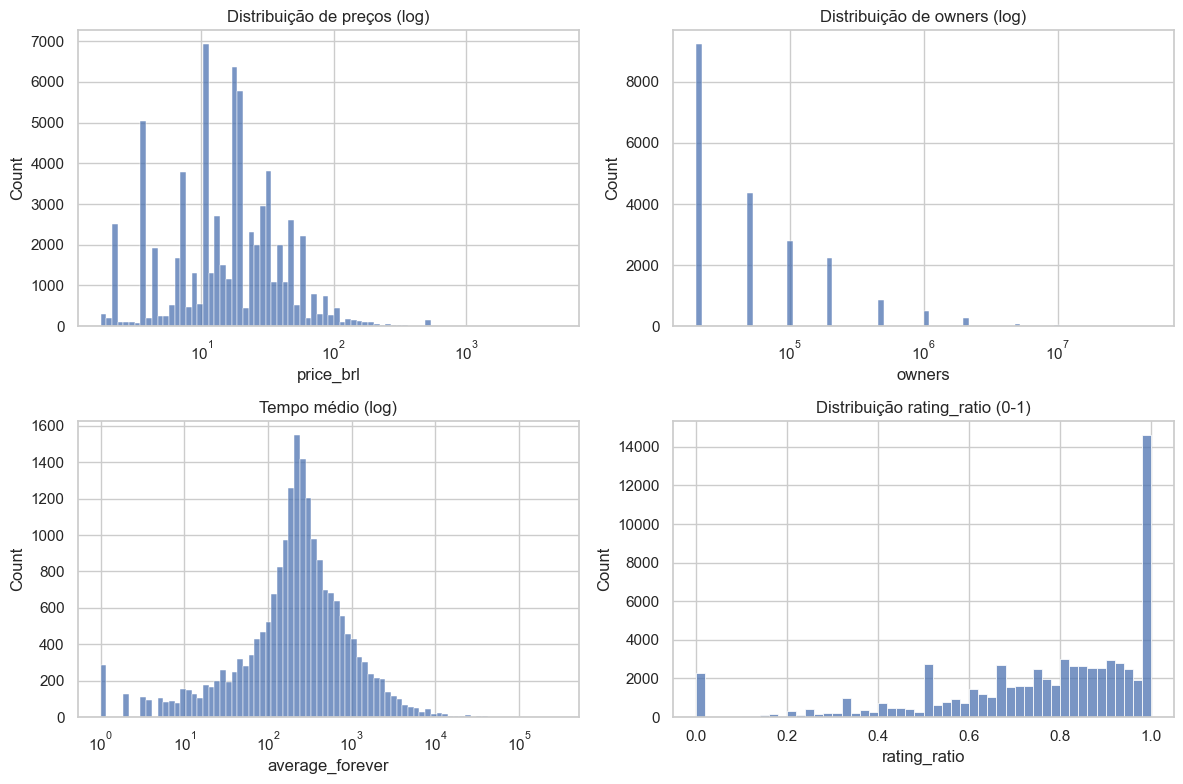


--- Preço x avaliação ---


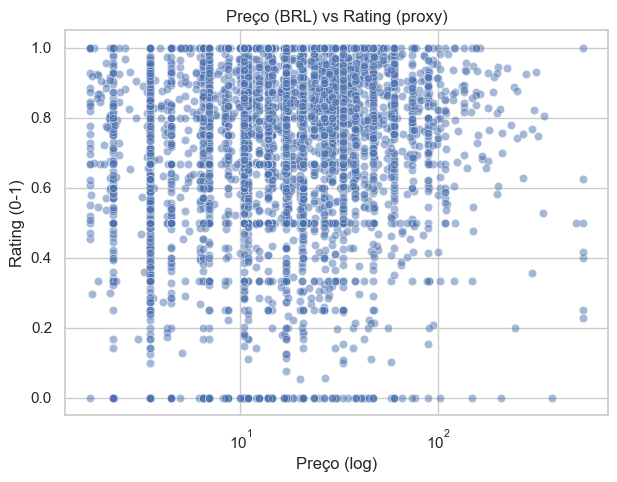

Spearman price vs rating_ratio: rho=0.0322, p=1.896e-17

--- Hipótese 1: free vs paid (owners) ---
N free=4, N paid=70,023
Mann-Whitney (owners_free>owners_paid): U=273223, p=1.901e-05


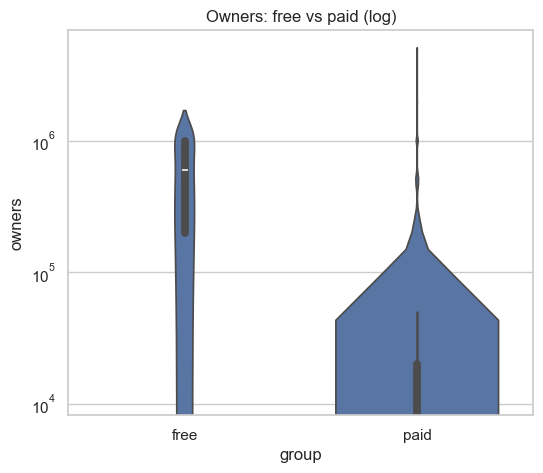


--- Hipótese 2: negative vs ccu ---
Spearman negative vs ccu: rho=0.5183, p=0


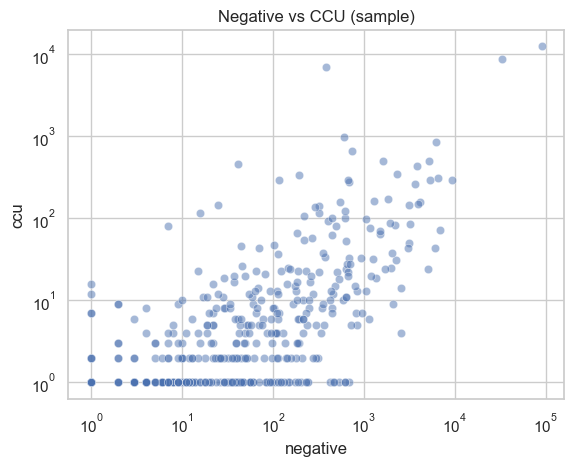


--- Multiplataforma vs single ---
Mann-Whitney (multi>single): U=490719722, p=4.088e-169


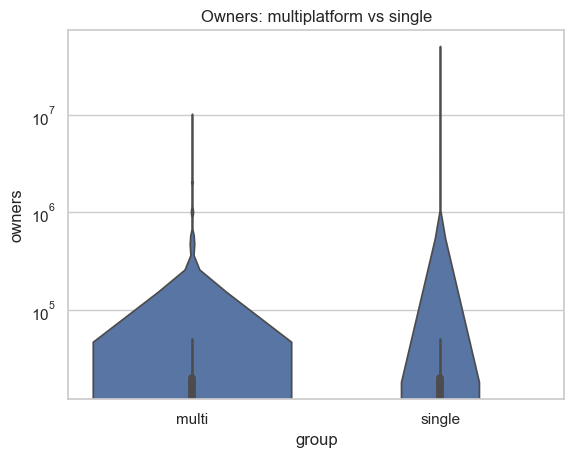


--- average_forever vs rating_ratio ---
Spearman rho=-0.0649, p=7.162e-66


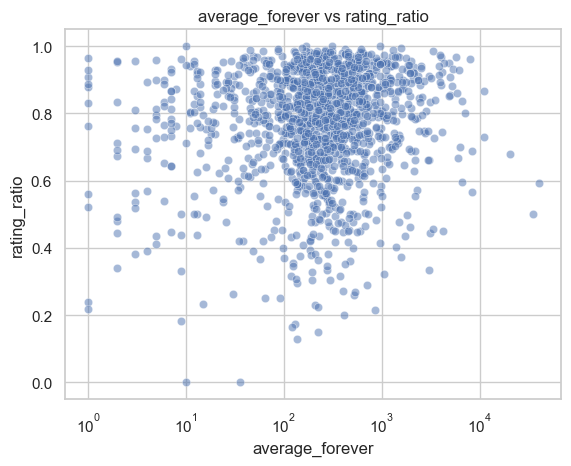


--- Gêneros: multiplayer_like vs singleplayer_like ---
genre_type
other                35590
singleplayer_like    33509
multiplayer_like       928
Name: count, dtype: int64


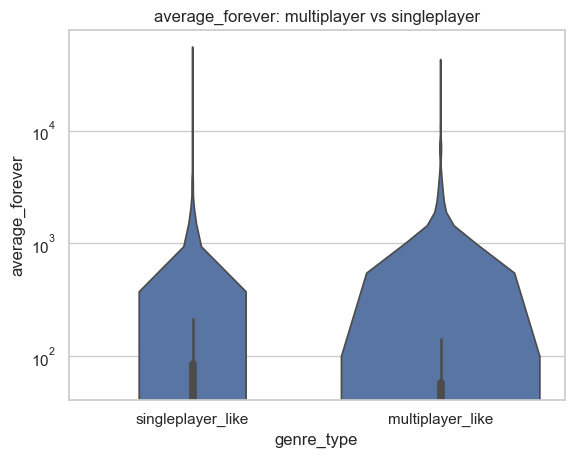

Mann-Whitney (multi>single): U=15543172, p=0.5082

--- Matriz de correlação (Spearman) ---
                        price_brl  rating_ratio  userscore_recalc_0_100  \
price_brl                   1.000         0.032                   0.032   
rating_ratio                0.032         1.000                   1.000   
userscore_recalc_0_100      0.032         1.000                   1.000   
average_forever             0.260        -0.065                  -0.065   
owners                      0.154        -0.036                  -0.036   
ccu                         0.355         0.065                   0.065   
positive                    0.298         0.071                   0.071   
negative                    0.248        -0.476                  -0.476   

                        average_forever  owners    ccu  positive  negative  
price_brl                         0.260   0.154  0.355     0.298     0.248  
rating_ratio                     -0.065  -0.036  0.065     0.071    -0.476  
us

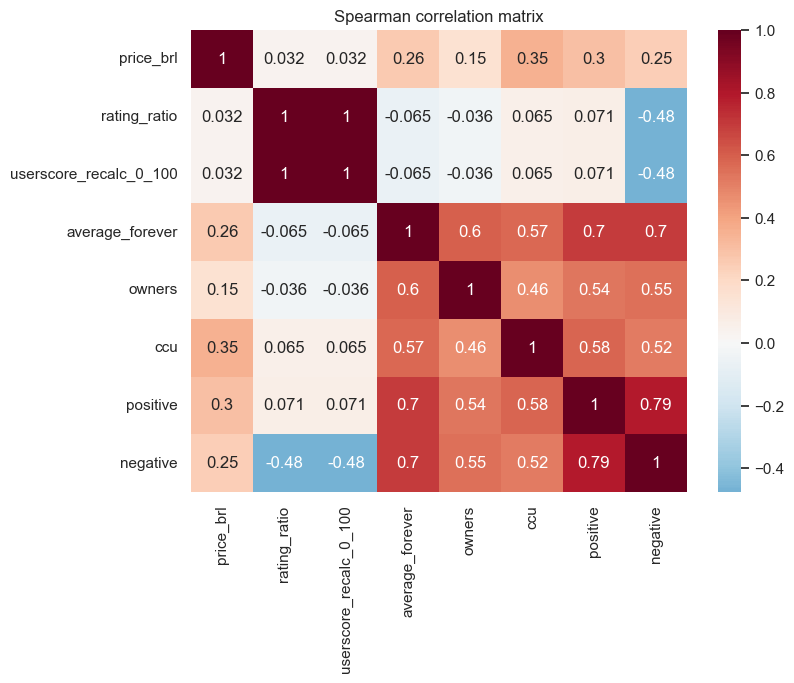


=== Resumo Rápido ===
- Total de jogos: 70,027
- Jogos pagos: 70,023
- Correlação (Spearman) preço-rating: 0.032 (p=1.9e-17)
- Testes: Mann-Whitney (owners free>paid), negative vs ccu Spearman, multiplatform vs single, average_forever vs rating.

Observações: distribuições enviesadas → testes não-paramétricos. Ajuste palavras-chave de gênero conforme necessário.

=== INTERPRETAÇÃO AUTOMÁTICA ===
→ A correlação Spearman entre preço e rating é positiva (0.032), significativa (p=1.9e-17).
   Isso sugere relação muito fraca — jogos mais caros não necessariamente têm avaliações melhores.

→ Diferença entre jogos gratuitos e pagos (owners):
   Diferença significativa (p=1.9e-05). Jogos gratuitos têm mais donos em geral.
   Média (free): 600,000, média (paid): 0
Gratuitos detectados: 4
Pagos detectados: 70023
                                      name  price_brl     owners
5456   Romance of the Three Kingdoms Maker      19.99   200000.0
11296                 The Archotek Project       3.49  

In [61]:
# Analise_3_4_matplotlib.py
# Versão sem Plotly — usa Seaborn + Matplotlib
# Faz análise exploratória e testes de hipótese sobre os Parquet tidy.

import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import duckdb

sns.set(style="whitegrid")

# ----------------------------
# 1) Carregar tabelas tidy
# ----------------------------
parquet_dir = Path("data/tidy")
files = {
    "games": parquet_dir / "games.parquet",
    "games_genres": parquet_dir / "games_genres.parquet",
    "games_developers": parquet_dir / "games_developers.parquet",
    "games_publishers": parquet_dir / "games_publishers.parquet",
    "games_platforms": parquet_dir / "games_platforms.parquet",
}

def read_table(path):
    if path.exists():
        try:
            return pd.read_parquet(path)
        except Exception as e:
            print(f"Erro lendo parquet {path}: {e}")
    csv_path = path.with_suffix(".csv")
    if csv_path.exists():
        print(f"Fallback CSV: {csv_path}")
        return pd.read_csv(csv_path)
    raise FileNotFoundError(f"Arquivo não encontrado: {path}")

print("Carregando tabelas...")
games = read_table(files["games"])
games_genres = read_table(files["games_genres"])
games_developers = read_table(files["games_developers"])
games_publishers = read_table(files["games_publishers"])
games_platforms = read_table(files["games_platforms"])

print(f"games: {len(games):,}")
print(f"games_genres: {len(games_genres):,}")
print(f"games_platforms: {len(games_platforms):,}")

# ----------------------------
# 2) Preparações / saneamento
# ----------------------------
for col in ["price_brl","is_free","positive","negative","owners","average_forever","ccu","userscore","metacritic"]:
    if col not in games.columns:
        games[col] = np.nan

num_cols = ["price_brl","positive","negative","owners","average_forever","ccu","userscore","metacritic"]
for c in num_cols:
    games[c] = pd.to_numeric(games[c], errors="coerce")

mask_votes = (games["positive"].fillna(0)+games["negative"].fillna(0))>0
games["rating_ratio"] = np.where(mask_votes,
                                 games["positive"]/(games["positive"]+games["negative"]),
                                 np.nan)
games["rating_ratio"] = games["rating_ratio"].clip(0,1)
games["userscore_recalc_0_100"] = (games["rating_ratio"]*100).round(2)

print("\nResumo de disponibilidade:")
for c in ["price_brl","rating_ratio","owners","ccu","average_forever"]:
    print(f"{c:20s} -> {games[c].notna().sum():,} / {len(games):,}")

paid_mask = (games["is_free"]==False) & (games["price_brl"].notna())
free_mask = (games["is_free"]==True)

# ----------------------------
# 3) Univariada
# ----------------------------
print("\n--- Univariada: distribuições ---")
fig, axes = plt.subplots(2,2, figsize=(12,8))
sns.histplot(games["price_brl"], bins=80, log_scale=True, ax=axes[0,0])
axes[0,0].set_title("Distribuição de preços (log)")
sns.histplot(games["owners"], bins=80, log_scale=True, ax=axes[0,1])
axes[0,1].set_title("Distribuição de owners (log)")
sns.histplot(games["average_forever"], bins=80, log_scale=True, ax=axes[1,0])
axes[1,0].set_title("Tempo médio (log)")
sns.histplot(games["rating_ratio"].dropna(), bins=50, ax=axes[1,1])
axes[1,1].set_title("Distribuição rating_ratio (0-1)")
plt.tight_layout()
plt.show()

# ----------------------------
# 4) Bivariada: preço x rating
# ----------------------------
print("\n--- Preço x avaliação ---")
df_scatter = games.loc[games["price_brl"].notna() & games["rating_ratio"].notna()]
if len(df_scatter)>5000:
    df_scatter = df_scatter.sample(5000, random_state=42)

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_scatter, x="price_brl", y="rating_ratio", alpha=0.5)
plt.xscale("log")
plt.title("Preço (BRL) vs Rating (proxy)")
plt.xlabel("Preço (log)")
plt.ylabel("Rating (0-1)")
plt.show()

mask_common = games["price_brl"].notna() & games["rating_ratio"].notna()
corr_spearman = stats.spearmanr(games.loc[mask_common,"price_brl"],
                                games.loc[mask_common,"rating_ratio"])
print(f"Spearman price vs rating_ratio: rho={corr_spearman.correlation:.4f}, p={corr_spearman.pvalue:.4g}")

# ----------------------------
# 5) Hipótese 1: owners free>paid
# ----------------------------
print("\n--- Hipótese 1: free vs paid (owners) ---")
owners_free = games.loc[free_mask, "owners"].dropna()
owners_paid = games.loc[paid_mask, "owners"].dropna()
print(f"N free={len(owners_free):,}, N paid={len(owners_paid):,}")

u = stats.mannwhitneyu(owners_free, owners_paid, alternative="greater")
print(f"Mann-Whitney (owners_free>owners_paid): U={u.statistic:.0f}, p={u.pvalue:.4g}")

df_box = pd.DataFrame({
    "owners": pd.concat([owners_free.sample(min(2000,len(owners_free)), random_state=1),
                         owners_paid.sample(min(2000,len(owners_paid)), random_state=1)]),
    "group": ["free"]*min(2000,len(owners_free)) + ["paid"]*min(2000,len(owners_paid))
})
plt.figure(figsize=(6,5))
sns.violinplot(data=df_box, x="group", y="owners", inner="box")
plt.yscale("log")
plt.title("Owners: free vs paid (log)")
plt.show()

# ----------------------------
# 6) Hipótese 2: negative x ccu
# ----------------------------
print("\n--- Hipótese 2: negative vs ccu ---")
mask_nc = games["negative"].notna() & games["ccu"].notna()
if mask_nc.any():
    corr2 = stats.spearmanr(games.loc[mask_nc,"negative"], games.loc[mask_nc,"ccu"])
    print(f"Spearman negative vs ccu: rho={corr2.correlation:.4f}, p={corr2.pvalue:.4g}")
    sns.scatterplot(data=games.loc[mask_nc].sample(min(2000,mask_nc.sum())),
                    x="negative", y="ccu", alpha=0.5)
    plt.xscale("log"); plt.yscale("log")
    plt.title("Negative vs CCU (sample)")
    plt.show()

# ----------------------------
# 7) Hipótese multiplataforma
# ----------------------------
print("\n--- Multiplataforma vs single ---")
plat_counts = games_platforms.groupby("appid").size().rename("plat_count").reset_index()
games = games.merge(plat_counts, on="appid", how="left")
games["plat_count"] = games["plat_count"].fillna(0).astype(int)
mult_mask = games["plat_count"]>1
single_mask = games["plat_count"]<=1

owners_multi = games.loc[mult_mask,"owners"].dropna()
owners_single = games.loc[single_mask,"owners"].dropna()
mw = stats.mannwhitneyu(owners_multi, owners_single, alternative="greater")
print(f"Mann-Whitney (multi>single): U={mw.statistic:.0f}, p={mw.pvalue:.4g}")

df_plat = pd.DataFrame({
    "owners": pd.concat([owners_multi.sample(min(2000,len(owners_multi)), random_state=1),
                         owners_single.sample(min(2000,len(owners_single)), random_state=1)]),
    "group": ["multi"]*min(2000,len(owners_multi)) + ["single"]*min(2000,len(owners_single))
})
sns.violinplot(data=df_plat, x="group", y="owners", inner="box")
plt.yscale("log")
plt.title("Owners: multiplatform vs single")
plt.show()

# ----------------------------
# 8) Hipótese: average_forever x rating_ratio
# ----------------------------
print("\n--- average_forever vs rating_ratio ---")
mask_af = games["average_forever"].notna() & games["rating_ratio"].notna()
if mask_af.any():
    af = games.loc[mask_af, "average_forever"]
    rr = games.loc[mask_af, "rating_ratio"]
    sp = stats.spearmanr(af, rr)
    print(f"Spearman rho={sp.correlation:.4f}, p={sp.pvalue:.4g}")
    sns.scatterplot(data=games.loc[mask_af].sample(min(5000,mask_af.sum())),
                    x="average_forever", y="rating_ratio", alpha=0.5)
    plt.xscale("log"); plt.title("average_forever vs rating_ratio")
    plt.show()

# ----------------------------
# 9) Gêneros multiplayer vs singleplayer
# ----------------------------
print("\n--- Gêneros: multiplayer_like vs singleplayer_like ---")
multiplayer_keywords = {"multiplayer","pvp","online","co-op","mmo","fps","battle"}
single_keywords = {"single-player","singleplayer","adventure","rpg","story","puzzle"}

genres_per_app = games_genres.groupby("appid")["genres"].apply(list).rename("genres_list").reset_index()
games = games.merge(genres_per_app, on="appid", how="left")

def classify_genre(gen_list):
    if not isinstance(gen_list,list): return "unknown"
    s = " ".join(gen_list).lower()
    if any(k in s for k in multiplayer_keywords): return "multiplayer_like"
    if any(k in s for k in single_keywords): return "singleplayer_like"
    return "other"

games["genre_type"] = games["genres_list"].apply(classify_genre)
print(games["genre_type"].value_counts().head(10))

df_compare = games.loc[
    games["genre_type"].isin(["multiplayer_like","singleplayer_like"]) &
    games["average_forever"].notna()
]
if len(df_compare)>0:
    sns.violinplot(data=df_compare, x="genre_type", y="average_forever", inner="box")
    plt.yscale("log")
    plt.title("average_forever: multiplayer vs singleplayer")
    plt.show()
    a = df_compare.loc[df_compare["genre_type"]=="multiplayer_like","average_forever"]
    b = df_compare.loc[df_compare["genre_type"]=="singleplayer_like","average_forever"]
    mw2 = stats.mannwhitneyu(a,b,alternative="greater")
    print(f"Mann-Whitney (multi>single): U={mw2.statistic:.0f}, p={mw2.pvalue:.4g}")

# ----------------------------
# 10) Matriz de correlações
# ----------------------------
print("\n--- Matriz de correlação (Spearman) ---")
num_for_corr = games[["price_brl","rating_ratio","userscore_recalc_0_100",
                      "average_forever","owners","ccu","positive","negative"]].copy()
corr = num_for_corr.corr(method="spearman", min_periods=50)
print(corr.round(3))
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0)
plt.title("Spearman correlation matrix")
plt.show()

# ----------------------------
# 11) Resumo textual
# ----------------------------
print("\n=== Resumo Rápido ===")
print(f"- Total de jogos: {len(games):,}")
print(f"- Jogos pagos: {paid_mask.sum():,}")
print(f"- Correlação (Spearman) preço-rating: {corr_spearman.correlation:.3f} (p={corr_spearman.pvalue:.3g})")
print("- Testes: Mann-Whitney (owners free>paid), negative vs ccu Spearman, multiplatform vs single, average_forever vs rating.")
print("\nObservações: distribuições enviesadas → testes não-paramétricos. Ajuste palavras-chave de gênero conforme necessário.")


# ----------------------------
# 12) Interpretação automática
# ----------------------------
print("\n=== INTERPRETAÇÃO AUTOMÁTICA ===")

# 1️⃣ Correlação preço vs rating
rho = corr_spearman.correlation
pval = corr_spearman.pvalue
if pval < 0.05:
    sig = "significativa"
else:
    sig = "não significativa"
direction = "positiva" if rho > 0 else "negativa"
print(f"→ A correlação Spearman entre preço e rating é {direction} ({rho:.3f}), {sig} (p={pval:.3g}).")
if abs(rho) < 0.2:
    print("   Isso sugere relação muito fraca — jogos mais caros não necessariamente têm avaliações melhores.")
elif rho > 0.3:
    print("   Indica que jogos mais caros tendem a ter avaliações ligeiramente melhores.")
else:
    print("   Indica correlação moderada, mas com bastante dispersão.")

# 2️⃣ Free vs Paid
print("\n→ Diferença entre jogos gratuitos e pagos (owners):")
if u.pvalue < 0.05:
    print(f"   Diferença significativa (p={u.pvalue:.3g}). Jogos gratuitos têm mais donos em geral.")
else:
    print(f"   Diferença não significativa (p={u.pvalue:.3g}). População similar em termos de owners.")

print(f"   Média (free): {owners_free.median():,.0f}, média (paid): {owners_paid.median():,.0f}")

print("Gratuitos detectados:", free_mask.sum())
print("Pagos detectados:", paid_mask.sum())

print(games.loc[free_mask, ["name","price_brl","owners"]].head(10))


# 3️⃣ Multiplataforma
print("\n→ Multiplataforma vs single:")
if mw.pvalue < 0.05:
    print(f"   Diferença significativa (p={mw.pvalue:.3g}). Jogos multiplataforma tendem a ter mais donos.")
else:
    print(f"   Diferença não significativa (p={mw.pvalue:.3g}).")
print(f"   Mediana owners multi: {owners_multi.median():,.0f}, single: {owners_single.median():,.0f}")

# 4️⃣ Relação tempo jogado x rating
if mask_af.any():
    if sp.pvalue < 0.05:
        print(f"\n→ Relação tempo jogado vs avaliação é significativa (rho={sp.correlation:.3f}, p={sp.pvalue:.3g}).")
        if sp.correlation > 0:
            print("   Jogadores que passam mais tempo tendem a avaliar melhor os jogos.")
        else:
            print("   Jogos mais longos parecem receber piores avaliações (possível saturação).")
    else:
        print(f"\n→ Sem correlação significativa entre tempo jogado e rating (p={sp.pvalue:.3g}).")

# 5️⃣ Multiplayer vs singleplayer
if len(df_compare)>0:
    if mw2.pvalue < 0.05:
        print(f"\n→ Diferença significativa entre multiplayer e singleplayer (p={mw2.pvalue:.3g}).")
        if mw2.statistic > 0:
            print("   Jogos multiplayer tendem a ter maior tempo médio de jogo.")
        else:
            print("   Singleplayers parecem reter mais tempo médio de jogo.")
    else:
        print(f"\n→ Diferença não significativa entre multiplayer e singleplayer (p={mw2.pvalue:.3g}).")

# 6️⃣ Correlação geral
print("\n→ Correlações mais fortes (|rho| > 0.3):")
strong_corrs = corr.stack()[abs(corr.stack())>0.3].sort_values(ascending=False)
print(strong_corrs)

print("\n=== Fim da análise ===")